In [84]:
import pandas as pd
import numpy as np
train = pd.read_csv(r'train.csv', index_col = 'id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
test = pd.read_csv(r'test.csv', index_col = 'id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
orig_train = pd.read_csv(r'Churn_Modelling.csv', index_col = 'RowNumber')

In [85]:
X = pd.concat([orig_train, train]).reset_index(drop = True)
y = X.pop('Exited')

In [86]:
from sklearn.preprocessing import FunctionTransformer

def salary_rounder(x):
    x_copy = x.copy()
    x_copy['EstimatedSalary'] = (x_copy['EstimatedSalary'] * 100).astype(np.uint64)
    return x_copy

SalaryRounder = FunctionTransformer(salary_rounder)

In [87]:
def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age'] * 10).astype(np.uint16)
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)

In [88]:
def feature_generator(x):
    
    x_copy = x.copy()
    #x_copy['IsSenior'] = (x_copy['Age'] >= 600).astype(np.uint8)
    x_copy['IsActive_by_CreditCard'] = x_copy['HasCrCard'] * x_copy['IsActiveMember']
    x_copy['Products_Per_Tenure'] =  x_copy['Tenure'] / x_copy['NumOfProducts']
    x_copy['ZeroBalance'] = (x_copy['Balance'] == 0).astype(np.uint8)
    x_copy['AgeCat'] = np.round(x_copy.Age/20).astype(np.uint16)#.astype('category')
    x_copy['AllCat'] = x_copy['Surname']+x_copy['Geography']+x_copy['Gender']+x_copy.EstimatedSalary.astype('str')+x_copy.CreditScore.astype('str')+x_copy.Age.astype('str')+x_copy.NumOfProducts.astype('str')+x_copy.Tenure.astype('str')+x_copy.CustomerId.astype('str')#+np.round(x_copy.IsActiveMember).astype('str')
    
    return x_copy

FeatureGenerator = FunctionTransformer(feature_generator)

In [89]:
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder, OrdinalEncoder
X = SalaryRounder.fit_transform(X)
X = AgeRounder.fit_transform(X)
X = FeatureGenerator.fit_transform(X)

In [91]:
encoder = CatBoostEncoder()
encoder.fit(X, y)

CatBoostEncoder(cols=['Surname', 'Geography', 'Gender', 'AllCat'])

In [92]:
X = CatBoostEncoder().fit_transform(X, y)

In [93]:
import torch
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [94]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=8888688)

In [95]:
X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)

In [96]:
Y_train = torch.tensor(Y_train.values, dtype=torch.float32)

In [97]:
Y_train = Y_train.unsqueeze(1).to(device)

In [98]:
X_val = torch.tensor(X_val.values, dtype=torch.float32).to(device)

In [99]:
Y_val = torch.tensor(Y_val.values, dtype=torch.float32)
Y_val = Y_val.unsqueeze(1).to(device)

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Binary(nn.Module):
    def __init__(self, input_dim):
        super(Binary, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, 4)
        self.batch_norm5 = nn.BatchNorm1d(4)
        self.fc5 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.batch_norm2(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.batch_norm3(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.batch_norm4(x)
        x = F.leaky_relu(self.fc4(x))
        x = self.batch_norm5(x)
        x = torch.sigmoid(self.fc5(x))
        return x

In [101]:
model =  Binary(X_train.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

# Train the model
num_epochs = 200
batch_size = 350
num_batches = len(X_train) // batch_size
loss_history=[]

for epoch in range(num_epochs):
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        inputs = X_train[start_idx:end_idx]
        labels = Y_train[start_idx:end_idx]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #scheduler.step()
    # Print the loss for every epoch
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        loss_history.append(loss.item())

Epoch [10/200], Loss: 0.3982
Epoch [20/200], Loss: 0.3215
Epoch [30/200], Loss: 0.3170
Epoch [40/200], Loss: 0.3144
Epoch [50/200], Loss: 0.3135
Epoch [60/200], Loss: 0.3134
Epoch [70/200], Loss: 0.3160
Epoch [80/200], Loss: 0.3154
Epoch [90/200], Loss: 0.3157
Epoch [100/200], Loss: 0.3146
Epoch [110/200], Loss: 0.3136
Epoch [120/200], Loss: 0.3136
Epoch [130/200], Loss: 0.3127
Epoch [140/200], Loss: 0.3127
Epoch [150/200], Loss: 0.3123
Epoch [160/200], Loss: 0.3117
Epoch [170/200], Loss: 0.3119
Epoch [180/200], Loss: 0.3135
Epoch [190/200], Loss: 0.3138
Epoch [200/200], Loss: 0.3151


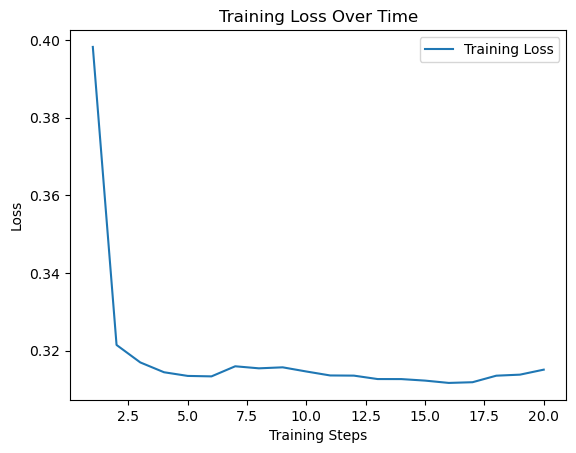

In [103]:
train_steps = range(1, len(loss_history) + 1)
import matplotlib.pyplot as plt
plt.plot(train_steps, loss_history, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Time')
plt.show()

In [104]:
torch.save(model.state_dict(), 'model1.pt')

In [105]:
X1 = test.copy()

In [106]:
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder, OrdinalEncoder
X1 = SalaryRounder.fit_transform(X1)
X1 = AgeRounder.fit_transform(X1)
X1 = FeatureGenerator.fit_transform(X1)

In [107]:
X1 = encoder.transform(X1)

In [108]:
X_test = torch.tensor(X1.values, dtype=torch.float32).to('cpu')

In [109]:
model = Binary(X_test.shape[1]).to("cpu")
model.load_state_dict(torch.load('model1.pt'))

<All keys matched successfully>

In [110]:
model = Binary(X_test.shape[1]).to("cpu")
# Make predictions on the test data
with torch.no_grad():
    test_predictions = model(X_test)

# Convert the predictions to numpy array
test_predictions = test_predictions.cpu().numpy()

# Print the predictions
print(test_predictions)

[[0.43148905]
 [0.63408345]
 [0.5924464 ]
 ...
 [0.55604136]
 [0.48224604]
 [0.5078084 ]]


## 模型的区分能力不够，需要进一步优化
1. 优化模型结构
2. 加深训练次数